In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from csaps import csaps
from scipy.signal import butter, freqs

%config InlineBackend.figure_formats = ['svg']

units are always mK, pJ, pW, Ohm, H, muA, V, s, Hz, mm, keV, g, ...

In [2]:
utils_par = {
    # 'bath_temperature': 11,  # mK
    'T_mc': 15,  # mK
    'T_shunt': 11,  # mK
    'Rh': 10,  # Ohm
    'Rs': 0.040,  # Ohm
    'L': 3.5e-7, # H 
    'sample_frequency': 25000,  # Hz
    'record_length': 16384, 
            }
utils_par['t'] = np.arange(0, utils_par['record_length'])/utils_par['sample_frequency']
utils_par['freq'] = np.fft.rfftfreq(utils_par['record_length'], d=1/utils_par['sample_frequency'])

b, a = butter(N=1, Wn=1e4, btype='lowpass', analog=True)
_, h = freqs(b, a, worN=utils_par['freq'])

utils_par['lowpass'] = np.abs(h) ** 2

# extract thermalization times from pulse shape

In [3]:
path = '../../rltest_data/'

names = ['li1p', 'li1l', 'li2p']

channels = {'li1p': 1, 'li1l': 2, 'li2p': 6,}

sev = {'li1p': np.loadtxt(path + 'Channel_0_SEV_Particle.xy', skiprows=3), 
       'li1l': np.loadtxt(path + 'Channel_1_SEV_Direct.xy', skiprows=3), 
       'li2p': np.loadtxt(path + 'Channel_5_SEV_Particle.xy', skiprows=3)}


## pulse shape fit

In [4]:
def pulse_template(t, t0, An, At, tau_n, tau_in, tau_t):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = (An * (np.exp(-(t[cond] - t0) / tau_n) - np.exp(-(t[cond] - t0) / tau_in)) + \
                   At * (np.exp(-(t[cond] - t0) / tau_t) - np.exp(-(t[cond] - t0) / tau_n)))
    return pulse

In [5]:
def single_pulse(t, t0, A, tau_rise, tau_decay):
    n = t.shape[0]
    cond = t > t0
    pulse = np.zeros(n)
    pulse[cond] = A * (np.exp(-(t[cond] - t0) / tau_decay) - np.exp(-(t[cond] - t0) / tau_rise))
    return pulse

In [6]:
pspars = {'li1p': [-2.74038416, 1.18433165, 1.04116448, 72.05835566, 0.38244691, 9.35751479], 
          'li1l': [-1.330066039435939, 1.0952134272841865, 0.6847593878712344, 17.83502246386849, 0.09396510359613783, 3.6836775281151417], 
          'li2p': [-2.06154929, 1.1372723, 0.94300337, 79.26274212, 0.39666609, 12.05657907]}

In [7]:
pspars_fit = {}
pspars_std = {}

for name in names:

    def cost_ch1(t0, An, At, tau_n, tau_in, tau_t):
        return np.sum((pulse_template(sev[name][:,0]*1000, t0, An, At, tau_n, tau_in, tau_t) - sev[name][:,1]) ** 2)

    m = Minuit(cost_ch1, *pspars[name])

    m.migrad()  # run optimiser
    m.hesse()   # run covariance estimator

    pspars_fit[name] = np.array(m.values)
    pspars_std[name] = np.sqrt(np.diag(list(m.covariance)))

In [8]:
pspars_fit

{'li1p': array([-2.74038416,  1.18433165,  1.04116448, 72.05835566,  0.38244691,
         9.35751479]),
 'li1l': array([-1.32994329,  1.05881848,  0.6562067 , 17.64370417,  0.09454686,
         3.61353113]),
 'li2p': array([-2.06154929,  1.1372723 ,  0.94300337, 79.26274212,  0.39666609,
        12.05657907])}

In [9]:
pspars_std

{'li1p': array([ 0.22560867,  0.22442485,  0.20168959, 74.50308501,  0.37004567,
         3.94790384]),
 'li1l': array([ 0.09817966,  0.3491554 ,  0.52171095, 19.58343486,  0.16269914,
         5.96930337]),
 'li2p': array([ 0.23489175,  0.18860638,  0.1845649 , 64.15240534,  0.37267798,
         5.47718372])}

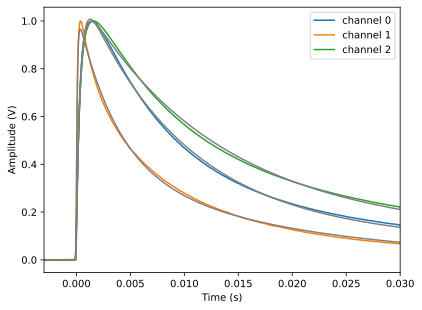

In [10]:
t0 = [-0.0027, -0.0013, -0.002]

for c,name in enumerate(names):
    plt.plot(sev[name][:,0] - t0[c], sev[name][:,1], label=f'channel {c}')
    plt.plot(sev[name][:,0] - t0[c], pulse_template(sev[name][:,0]*1000, *pspars_fit[name]), color='grey')
    
plt.xlim(-0.003,0.03)
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (V)')
plt.show()

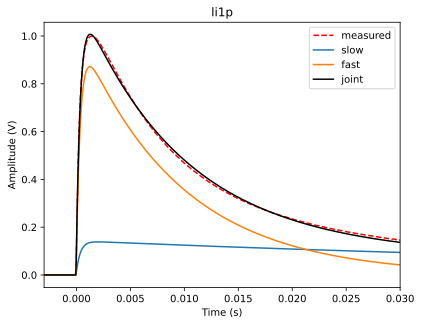

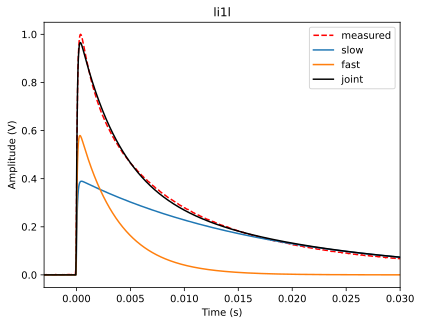

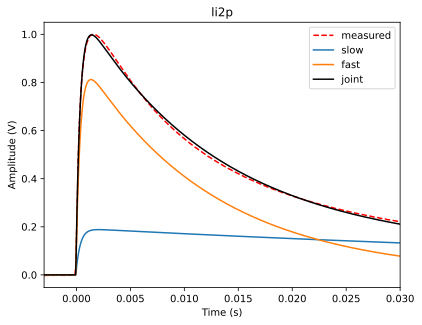

In [11]:
t0 = [-0.0027, -0.0013, -0.002]

for c,name in enumerate(names):
    plt.plot(sev[name][:,0] - t0[c], sev[name][:,1], 
             label='measured', color='red', linestyle='dashed')
    fast_pulse = single_pulse(sev[name][:,0]*1000, 
                          pspars_fit[name][0], 
                          pspars_fit[name][2],
                          pspars_fit[name][4],
                          pspars_fit[name][5])
    slow_pulse = single_pulse(sev[name][:,0]*1000, 
                          pspars_fit[name][0],
                          pspars_fit[name][1] - pspars_fit[name][2],
                          pspars_fit[name][4],
                          pspars_fit[name][3])
    plt.plot(sev[name][:,0] - t0[c], slow_pulse, label='slow')
    plt.plot(sev[name][:,0] - t0[c], fast_pulse, label='fast')
    plt.plot(sev[name][:,0] - t0[c], fast_pulse + slow_pulse, 
             color='black', label='joint')
    
    plt.xlim(-0.003,0.03)
    plt.legend()
    plt.title(name)
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (V)')
    plt.show()

In [12]:
Afast = {}
Aslow = {}
tau_rise = {}
tau_fast = {}
tau_slow = {}

for name in names:
    Afast[name] = pspars_fit[name][2]
    Aslow[name] = pspars_fit[name][1]
    tau_rise[name] = pspars_fit[name][4]*1e-3  # s
    tau_fast[name] = pspars_fit[name][5]*1e-3  # s
    tau_slow[name] = pspars_fit[name][3]*1e-3  # s

In [13]:
Afast

{'li1p': 1.04116448, 'li1l': 0.6562067007438482, 'li2p': 0.94300337}

In [14]:
Aslow

{'li1p': 1.18433165, 'li1l': 1.0588184755753902, 'li2p': 1.1372723}

In [15]:
tau_rise

{'li1p': 0.00038244691, 'li1l': 9.454685694926807e-05, 'li2p': 0.00039666609}

In [16]:
tau_fast

{'li1p': 0.00935751479, 'li1l': 0.0036135311278728123, 'li2p': 0.01205657907}

In [17]:
tau_slow

{'li1p': 0.07205835566,
 'li1l': 0.017643704166800684,
 'li2p': 0.07926274212000001}

## transition curve splines

In [21]:
tes_rt0 = {'li1p': 0.110, 'li1l': 0.115, 'li2p': 0.100, }  # Ohm

In [18]:
# Attention - this curve is actually taken with 1 muA!

transition_curves = np.loadtxt(path + 'rl_tests.xy', skiprows=5)[2600:10000]

transition_curves = {'li1p': transition_curves[:,[0,1]], 
                     'li1l': transition_curves[:,[0,2]], 
                     'li2p': transition_curves[:,[0,3]]}

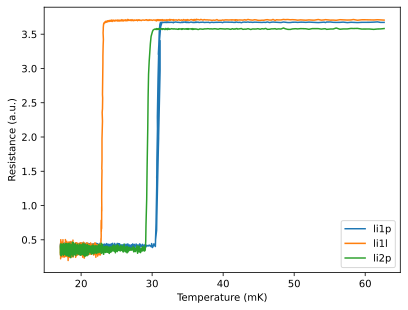

In [20]:
for name in names:
    plt.plot(transition_curves[name][:,0], transition_curves[name][:,1], label=name)
plt.ylabel('Resistance (a.u.)')
plt.xlabel('Temperature (mK)')
plt.legend()
plt.show()

In [22]:
transition_curves_sorted = {}
transition_curves_cleaned = {}
temp_grids = {'li1p': np.linspace(25,35, 1000),
              'li1l': np.linspace(18,28, 1000),
              'li2p': np.linspace(20,35, 1000),}
transition_curve_splines = {}
transition_curve_derivative_splines = {}
xlims = {'li1p': (29.5,32.5),
         'li1l': (22,24),
         'li2p': (28,32),}

for name in names:
    transition_curves_sorted[name] = np.sort(transition_curves[name], axis=0)

    transition_curves_cleaned[name] = []
    for v in np.unique(transition_curves_sorted[name][:,0]):
        transition_curves_cleaned[name].append(np.mean(
            transition_curves_sorted[name][transition_curves_sorted[name][:,0] == v], axis=0))
    transition_curves_cleaned[name] = np.array(transition_curves_cleaned[name])
    
    transition_curves[name][:,1] = transition_curves[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    transition_curves_cleaned[name][:,1] = transition_curves_cleaned[name][:,1]/np.max(transition_curves_cleaned[name][:,1]) * tes_rt0[name]
    
    transition_curve_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           transition_curves_cleaned[name][:,1], 
                                           temp_grids[name], smooth=0.99999)
    
    transition_curve_derivative_splines[name] = csaps(transition_curves_cleaned[name][:,0], 
                                           np.gradient(transition_curves_cleaned[name][:,1], 
                                                       transition_curves_cleaned[name][:,0]), 
                                           temp_grids[name], smooth=0.9999)

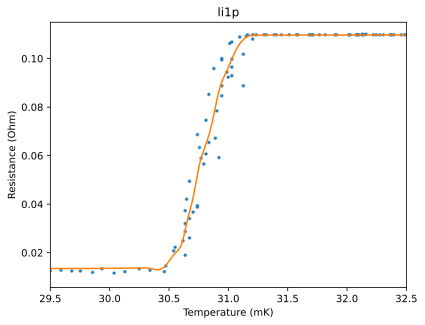

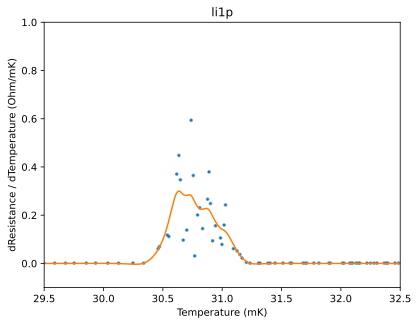

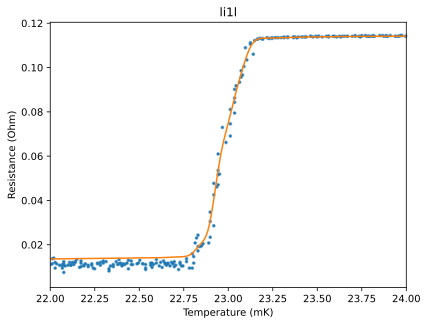

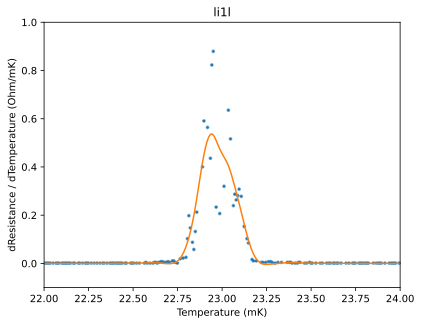

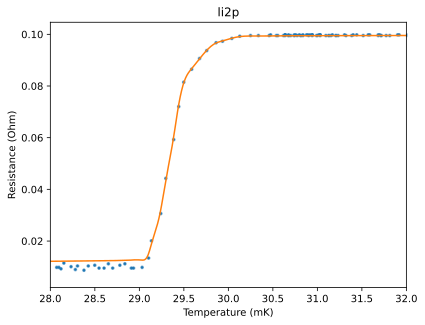

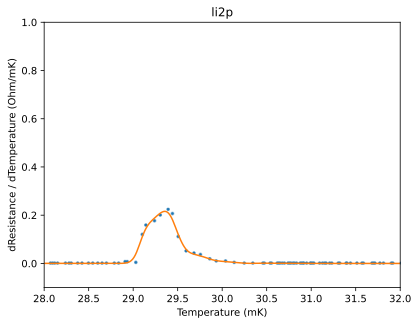

In [23]:
for name in names:
    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.title(name)
    plt.xlim(xlims[name])
    plt.show()
    
    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1)
    plt.show()

## pulse heights in temperature

SQUID sensitivity * 100

U / phi0 8.65

I / phi0 0.15

In [24]:
# for this we need the transition curve and the OP at the point where A_fast was measured
# scale the transition curve to the bias current and get derivative at DAC
# get V/phi_0 from Heater bias client: Phi-0 [Volt / Phi-0]: 8.65
# the input coil sensitivity is then 0.15 muA/phi_0
# therefore 8.65 V PH = 0.15 muA PH * der sensitivity range (zehnerpotenz)
# sensitivity range get from squid client - it is * 100

v_to_muA = 0.15 / 8.65 * 10

In [25]:
# bias currents were: Li1P 2.8, Li1L 0.84, Li2P 3.0
# V_sets were: Li1P 1.55, Li1L 0.287, Li2P 2.5

bias = {'li1p': 0.28 * 17.86, 'li1l': 0.084 * 17.86, 'li2p': 0.336 * 17.86,}
v_sets = {'li1p': 1.55, 'li1l': 0.287, 'li2p': 2.5,} 

In [26]:
# and we need A_fast in term of temperature

I_squid_op = {}
V_op = {}
R_op = {}

for name in names:

    I_squid_op[name] = v_to_muA * v_sets[name]
    V_op[name] = bias[name] / v_to_muA / (utils_par['Rs'] / tes_rt0[name] + 1) - v_sets[name]
    R_op[name] = utils_par['Rs'] / (bias[name] / v_to_muA / V_op[name] - 1)
    

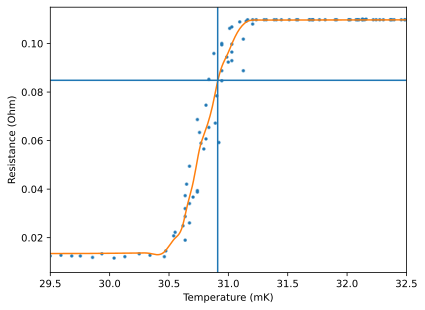

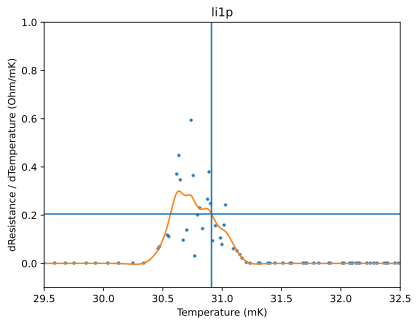

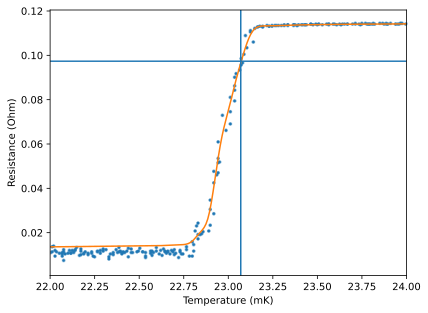

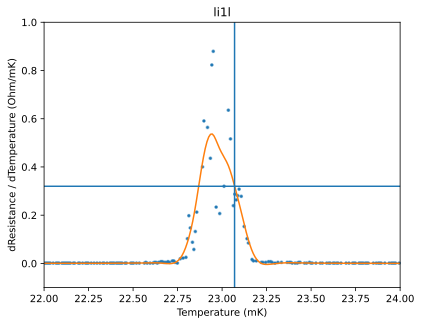

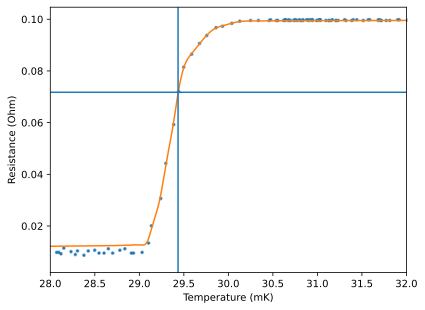

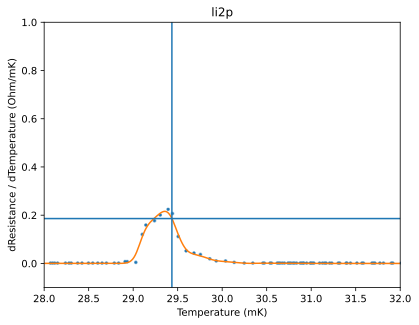

In [27]:
# eval derivative of transition curve at all OPs

T_op = {'li1p': 30.91, 'li1l': 23.07, 'li2p': 29.435}
dRdT_op = {'li1p': 0.205, 'li1l': 0.32, 'li2p': 0.186}

for name in names:

    plt.scatter(transition_curves[name][:,0], transition_curves[name][:,1], s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_splines[name], color='C1')
    plt.axhline(R_op[name])
    plt.axvline(T_op[name])
    plt.xlabel('Temperature (mK)')
    plt.ylabel('Resistance (Ohm)')
    plt.xlim(xlims[name])
    plt.show()

    plt.scatter(transition_curves_cleaned[name][:,0], 
                np.gradient(transition_curves_cleaned[name][:,1], transition_curves_cleaned[name][:,0]), s=5, rasterized=True)
    plt.plot(temp_grids[name], transition_curve_derivative_splines[name], color='C1')
    plt.axvline(T_op[name])
    plt.axhline(dRdT_op[name])
    plt.xlabel('Temperature (mK)')
    plt.ylabel('dResistance / dTemperature (Ohm/mK)')
    plt.xlim(xlims[name])
    plt.title(name)
    plt.ylim(-0.1,1)
    plt.show()


In [28]:
# linearize the transition curve:
# around the OP it is roughly R(T + deltaT) = R_op + dRdT_op * deltaT
# we invert to deltaT = (R(T + deltaT) - R_op) / dRdT_op
# but this is also deltaT = (R(Vop + deltaVph) - R_op) / dRdT_op if we can linearize the R function as well

# linearize the function for the resistance:
# R(Vop + deltaVph) = Rref / (Ib / u / (Vop + deltaVph) - 1), with u = (I/phi_0) * (phi0/U) * sensitivitySQUID 
# the derivative for V at the OP is = u * Rref * Ib / (Ib - u * V_op) ** 2
# around the OP it is threfore linearized to R(Vop + deltaVph) = Rref / (Ib / u / Vop - 1) + u * Rref * Ib / (Ib - u * V_op) ** 2 * deltaVph

Vph_iron = {'li1p': 0.37, 'li1l': 3.3, 'li2p': 0.523}
R_iron = {}  # resistance increase for iron events
Tph_iron = {}

for name in names:
    
    R_iron[name] = utils_par['Rs'] / (bias[name] / v_to_muA / V_op[name] - 1) + v_to_muA * utils_par['Rs'] * bias[name] / (bias[name] - v_to_muA * V_op[name]) ** 2 * Vph_iron[name] 
    Tph_iron[name] = (R_iron[name] - R_op[name]) / dRdT_op[name]


In [29]:
Tph_iron

{'li1p': 0.024384679367548862,
 'li1l': 0.5621356048368926,
 'li2p': 0.025365374899978907}

# calc detector properties

In [30]:
# below are constants of nature

kB = 1.380649e-17  # mm ^ 2 * g / s^2 / mK     # nJ / mK
na = 6.02214076e23  # number of items per mole
h_const = 6.62607015e-34  # kg * m^2 / s
e_charge = 1.60217663e-19  # coulombs

In [31]:
density = {'W': 0.01935, 'Au': 0.01932, 'Al': 0.002702, 'CaWO4': 0.00606, 'Si': 0.00233, 'Al2O3': 0.00398, 'LiAlO2': 0.002615, 'Cu': 0.0089, }  # g/mm^3
molar_mass = {'W': 183.84, 'Au': 196.96655, 'Al': 26.981538, 'CaWO4': 287.9156, 'Si': 28.0855, 'Al2O3': 101.961276, 'LiAlO2': 65.92, 'Cu': 63.546, }  # g/mole

energy_gap = {'CaWO4': 5.2e-3, 'Si': 1.12e-3, 'Al203': 8.3e-3, 'LiAlO2': 4.59, 'Cu': 0.0, }  # keV
sommerfeld_constant = {'W': 1.01e3, 'Au': 0.729e3, 'Al': 1.356e3, 'Cu': 0.7e3, }  # pJ / mol / mK^2 ; gold value is from Florians book
fermi_temp = {'W': 27_000_000, 'Au': 63_900_000, 'Al': 134_900_000, 'Cu': 8_160_000, }  # mK
electron_phonon_coupling = {'W': 2.1e-4}  # pW / mK^6 / mm^3 - multiply with T^5 (mK) and volume (mm^3)
thermal_conductivity = {'Au': 17.1e3}  # pW / mK^2 / mm - multiply with temperature (mK) and cross section (mm^2), divide by length (mm) 


In [32]:
# speed of sound 
K_mod = {'LiAlO2': 94, 'Al2O3': 232, 'Si': 83, 'Cu': 39,}  # bulk modulus, GPa
G_mod = {'LiAlO2': 53, 'Al2O3': 149, 'Si': 63, 'Cu': 53,}   # shear modulus, GPa
s_long = {}
s_trans = {}
s_eff = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:

    s_long[name] = np.sqrt( (K_mod[name] + 4/3*G_mod[name]) / density[name] * 1e3 ) # sqrt( 10**6 / s ** 2 / mm * mole )
    s_trans[name] = np.sqrt( G_mod[name] / density[name] * 1e3)  # sqrt( 10**6 / s ** 2 / mm * mole )
    s_eff[name] = ((1/3) * s_long[name] ** (-3) + (2/3) * s_trans[name] ** (-3) ) ** ( - 1 / 3)  # m/s
    

In [33]:
# atomic density lithium aluminate
n_atom = {}

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    n_atom[name] = density[name] / (molar_mass[name] / na) * 1e9  # 1/m^3
    print(name, n_atom[name])

LiAlO2 2.388940850637136e+28
Al2O3 2.3507081477481704e+28
Si 4.996025696818643e+28
Cu 8.43437081232493e+28


In [34]:
# Debye freqency is ω^3_D=6π^2nc^3. (https://lampx.tugraz.at/~hadley/ss1/phonons/table/dosdebye.html)

for name in ['LiAlO2', 'Al2O3', 'Si', 'Cu']:
    deb_freq = (6 * np.pi ** 2 * n_atom[name] * s_eff[name] ** 3) ** (1/3)  # rad / sec
    print('deb freq', name, deb_freq*1e-12/2/np.pi, 'in THz')
    # print(name, deb_freq * h_const / kB, 'in mK')
    td = deb_freq/2/np.pi * h_const / kB * 1e9 # mK
    print('deb temp', name, td, 'in mK')
    
# debye model phonon heat resistance
# http://lampx.tugraz.at/~hadley/ss2/transport/phonon_Boltzmann.php

deb freq LiAlO2 8.943137886280796 in THz
deb temp LiAlO2 429202.92554892146 in mK
deb freq Al2O3 12.051032854168913 in THz
deb temp Al2O3 578358.3595227894 in mK
deb freq Si 13.111905093419978 in THz
deb temp Si 629272.1969823111 in mK
deb freq Cu 7.216316271648248 in THz
deb temp Cu 346328.5588192781 in mK


In [35]:
# below are constants of the materials

debye_frequency = {'CaWO4': 4.7, 'Si': 13.5, 'Al2O3': 21.7,  # from pantic thesis , THz
                   'LiAlO2': 8.94, 'Cu': 7.22, }  # calc above
                # mK  # debye_temp * h_const / kB
debye_temp = {'W': 383_000, 'Au': 162_000, 'Al': 428_000, 'CaWO4': 228_000, 'Si': 648_000, 'Al2O3': 1_041_000,  # from pantic thesis 
              'LiAlO2': 429_202, 'Cu': 346_328, }  # mK  # calc above


In [36]:
abs_material = {'li1p': 'LiAlO2', 'li1l': 'Al2O3', 'li2p': 'LiAlO2', }
abs_volume = {'li1p': 4000, 'li1l': 200, 'li2p': 4000, }  # mm^3
abs_surface = {'li1p': 1600, 'li1l': 840, 'li2p': 1600, }  # mm^2

# phonon size M, light size S 
tes_thickness = {'li1p': 0.0002, 'li1l': 0.0002, 'li2p': 0.0002, }  # mm
tes_surface = {'li1p': 2.04, 'li1l': 1.02, 'li2p': 2.04, }  # mm^2 
pc_surface = {'li1p': 16.53, 'li1l': 7.6, 'li2p': 16.53, }  # mm^2
thermal_link_width = {'li1p': 0.040, 'li1l': 0.040, 'li2p': 0.040, }  # mm
thermal_link_thickness = {'li1p': 0.000080, 'li1l': 0.000080, 'li2p': 0.000080, }  # mm
thermal_link_length = {'li1p': 0.61, 'li1l': 1., 'li2p': 0.61, }  # mm

tes_tc = {'li1p': 31, 'li1l': 22.5, 'li2p': 29, }  # mK
tes_width = {'li1p': 1, 'li1l': 1.7, 'li2p': 1.5, }  # mK


## copper holders

In [37]:
tau_holder = {'li1p': 200, 'li1l': 100, 'li2p': 200,}
volume_holder = dict([(name, 400) for name in names])

C_holder = {}

for name in names:
    mat = 'Cu'
    n_mol = volume_holder[name] * density[mat] / molar_mass[mat] 
    C_holder[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3

G_holder = dict([(name, C_holder[name]/tau_holder[name]) for name in names])

In [38]:
C_holder

{'li1p': 0.07741781281321224,
 'li1l': 0.03218745698221213,
 'li2p': 0.06685532476667837}

In [39]:
G_holder

{'li1p': 0.0003870890640660612,
 'li1l': 0.0003218745698221213,
 'li2p': 0.00033427662383339184}

## heat capacity absorber phonons and TES electrons

In [40]:
# values from literature

Ref: sisti (2001)

|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Toperating (mK) |  19.3 |  12.3 |  16.7  | 10 | 
 | Ca (pJ/mK)  | 0.1595 |  0.041.7 |  0.103  | 0.0221 | 

 **Thermometer** 
|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Thermometer Area (mm^2)  | 117  | 72  | 72 | 72 | 
 | Thermometer Thickness (mm) |  0.000210  | 0.000130  | 0.000180 |  0.000180 | 
 | Thermometer Rth (n.c.) (Ohm) |  0.193 |  0.160 |  0.210 |  0.290 | 
 | Thermometer Roperating (Ohm)  | 0.161  | 0.070  | 0.125 |  0.095 | 
 | Thermometer Ce (pJ/mK)  | 0.0677 |  0.022  | 0.036 |  0.0269 | 


In [41]:
Cph_mm3 = {}  # pJ / mK / mm^3
Ce_mm3 = {}  # pJ / mK / mm^3
Cph = {}  # pJ / mK
Ce = {}  # pJ / mK
Cph_tes = {}  # pJ / mK  # we ignore this in the end!

for name in names:
    mat = abs_material[name]
    n_mol_mm3 = density[mat] / molar_mass[mat] 
    Cph_mm3[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol_mm3 * 1e3
    
    n_mol = abs_volume[name] * density[mat] / molar_mass[mat] 
    Cph[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp[mat]) ** 3 * n_mol * 1e3
    
    n_mol_mm3 = density['W'] / molar_mass['W']
    Ce_mm3[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol_mm3 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W']
    Ce[name] = sommerfeld_constant['W'] * T_op[name] * (2.43 - 1.43 * R_op[name] / tes_rt0[name]) * n_mol 
    
    n_mol = tes_surface[name] * tes_thickness[name] * density['W'] / molar_mass['W'] 
    Cph_tes[name] = 12 * np.pi ** 4 / 5 * na * kB * (T_op[name] / debye_temp['W']) ** 3 * n_mol * 1e3

    

In [42]:
Cph  # same OOM than sisti

{'li1p': 0.11520496796414059,
 'li1l': 0.00016516321135009383,
 'li2p': 0.09948699489302736}

In [43]:
Ce  # factor 20 smaller than sisti (expected)

{'li1p': 0.001779209829441156,
 'li1l': 0.0006101503246444132,
 'li2p': 0.001792532084039929}

In [44]:
Cph_tes  # ignored

{'li1p': 4.3877990717937795e-08,
 'li1l': 9.121421074676087e-09,
 'li2p': 3.789150342744373e-08}

## Couplings

In [45]:
# ----------
# TODO - HERE IS WHERE THE TROUBLE BEGINS!!
# the calculated capacities and couplings would lead to much too short athermal pulse components
# (see below)
# ----------

### calculate values from literature 

Ref: sisti (2001)

**Thermal coupling** 
|  | No 1 | No 2 | No 3  | No 4  |
|---|---|---|---|---|
 | Thermal coupling No. of Au wires  | 2 |  1 |  2 |  2 | 
 | Thermal coupling Diameter (mm)  | 0.025 |  0.025 |  0.025 |  0.025 | 
 | Thermal coupling Length (mm)  | 20 |  30  | 25  | 25 | 
 | Thermal coupling GAu (pW/mK) |  18.2 |  3.8 |  22.4 |  13.4 | 


In [46]:
# pantic

In [47]:
eph_coupling_calc = {}  # pW/mK
thermal_link_calc = {}  # pW/mK

for name in names:
    tes_vol = tes_surface[name] * tes_thickness[name] 
    eph_coupling_calc[name] = electron_phonon_coupling['W'] * T_op[name] ** 5 * tes_vol
    thermal_link_calc[name] = thermal_conductivity['Au'] * (T_op[name] + utils_par['T_mc'])/2 * thermal_link_width[name] * thermal_link_thickness[name] / thermal_link_length[name] 
    

In [48]:
eph_coupling_calc

{'li1p': 2.4175445345505824,
 'li1l': 0.2799544884039746,
 'li2p': 1.8932137873629769}

In [49]:
thermal_link_calc  # factor 2-10 smaller than sisti, but we would need factor > 20

{'li1p': 2.059176393442623,
 'li1l': 1.0415952000000002,
 'li2p': 1.993019016393443}

### get values from data

In [50]:
# here the fit should be:
# Geff = Cop / tau_eff(fit)
# Geff = Geb + G_ETF(calc)
# tau_eff(fit) = tau_in / (1 + G_ETF(calc)/G_eb)

In [51]:
I_f = {}  # muA
G_etf = {}  # pW/mK
G_eff = {}  # pW/mK

for name in names:
    I_f[name] = bias[name] / (1 + R_op[name]/utils_par['Rs'])
    G_etf[name] = I_f[name]**2 * dRdT_op[name] * (R_op[name] - utils_par['Rs'])/(R_op[name] + utils_par['Rs'])
    G_eff[name] = Ce[name] / tau_fast[name]

In [52]:
I_f  # muA

{'li1p': 1.6023327938342968,
 'li1l': 0.4369274958045869,
 'li2p': 2.148086011560693}

In [53]:
G_etf

{'li1p': 0.18904215140609568,
 'li1l': 0.02550641044682458,
 'li2p': 0.24381808732609}

In [54]:
G_eff

{'li1p': 0.19013700425486113,
 'li1l': 0.16885154798807342,
 'li2p': 0.1486766746713609}

In [55]:
# TODO values would match the calculated thermal links and couplings
# but they would lead to too short pulses by factor up to 10! (as said above)

In [56]:
# TODO in the remainder of this section we try to take the couplings only from data
# but we know this cannot be correct. anyway, lets see where this leads us ...

# also, we need apparently a large coupling of the absorber to the bath for the phonon detectors

In [57]:
for name in names:
    print(name, 'Gab !< ', Cph[name]/tau_slow[name], ', Geb !< ', Ce[name]/tau_fast[name])

li1p Gab !<  1.5987732013720029 , Geb !<  0.19013700425486113
li1l Gab !<  0.009361028148549076 , Geb !<  0.16885154798807342
li2p Gab !<  1.2551545938495137 , Geb !<  0.1486766746713609


Yeah that needs some calculation ...

In [58]:
from sympy import solve
from sympy import symbols

In [59]:
alpha, Geb, Gae, C_e, C_a, t_f, t_s = symbols('alpha thermal_link eph_coupling Ce Cph tau_fast tau_slow')

In [60]:
eq1 = 1/(1/alpha/Geb + 1/Gae) + Geb - C_e/t_f
eq2 = 1/(1/Geb + 1/Gae) + alpha*Geb - C_a/t_s

In [61]:
solve([eq1, eq2], [Geb, Gae], dict=True)

[{eph_coupling: -Ce*Cph*(alpha - 1)*(Ce*alpha*tau_slow - Cph*tau_fast)/((Ce*tau_slow - Cph*tau_fast)*(Ce*alpha**2*tau_slow - Cph*tau_fast)),
  thermal_link: Ce*Cph*(alpha - 1)/(Ce*alpha**2*tau_slow - Cph*tau_fast)}]

And continue.

In [62]:
alpha_min = {}

for name in names:
    alpha_min[name] = Cph[name] / Ce[name] * tau_fast[name] / tau_slow[name] - 1
    print(name, 'Gab/Geb !> ', alpha_min[name])

li1p Gab/Geb !>  7.408532613825107
li1l Gab/Geb !>  -0.9445606021378598
li2p Gab/Geb !>  7.442175590918634


In [63]:
for name in names:
    print(name, 'Guess for absorber-bath coupling (alpha): ', Cph[name] / tau_slow[name] / ( Ce[name] / tau_fast[name] ))

li1p Guess for absorber-bath coupling (alpha):  8.408532613825107
li1l Guess for absorber-bath coupling (alpha):  0.05543939786214029
li2p Guess for absorber-bath coupling (alpha):  8.442175590918634


In [64]:
eph_coupling = {}
thermal_link = {}
absorber_bath = {}

# alpha = {'li1p': 55, 'li1l': 0., 'li2p': 45, }  # ratio Gab/Geb - tuned to get good ratio of thermal link
alpha = {'li1p': 9, 'li1l': 0., 'li2p': 9, }  # - tuned to get larger thermal link (needed for noise)

for name in names:
    eph_coupling[name] = -Ce[name]*Cph[name]*(alpha[name] - 1)*(Ce[name]*alpha[name]*tau_slow[name] - Cph[name]*tau_fast[name])/((Ce[name]*tau_slow[name] - Cph[name]*tau_fast[name])*(Ce[name]*alpha[name]**2*tau_slow[name] - Cph[name]*tau_fast[name]))
    thermal_link[name] = Ce[name]*Cph[name]*(alpha[name] - 1)/(Ce[name]*alpha[name]**2*tau_slow[name] - Cph[name]*tau_fast[name])
    absorber_bath[name] = alpha[name]*thermal_link[name]
    print('alpha < Ca/tau_slow/Geb: ' , alpha[name], ' <= ', Cph[name]/tau_slow[name]/thermal_link[name],  alpha[name] <= Cph[name]/tau_slow[name]/thermal_link[name])
    print('tau_fast < Ce/Geb: ', tau_fast[name], ' <= ', Ce[name]/thermal_link[name], tau_fast[name] <= Ce[name]/thermal_link[name])

alpha < Ca/tau_slow/Geb:  9  <=  9.073933423271862 True
tau_fast < Ce/Geb:  0.00935751479  <=  0.010098012353800673 True
alpha < Ca/tau_slow/Geb:  0.0  <=  0.05543939786214029 True
tau_fast < Ce/Geb:  0.0036135311278728123  <=  0.003613531127872812 False
alpha < Ca/tau_slow/Geb:  9  <=  9.069728051135169 True
tau_fast < Ce/Geb:  0.01205657907  <=  0.012952809641810505 True


In [65]:
eph_coupling

{'li1p': 0.014066623932673881,
 'li1l': 0.009910457970999329,
 'li2p': 0.010372908719221963}

In [66]:
thermal_link

{'li1p': 0.1761940634556166,
 'li1l': 0.16885154798807342,
 'li2p': 0.13838944087109847}

In [67]:
absorber_bath

{'li1p': 1.5857465711005494, 'li1l': 0.0, 'li2p': 1.2455049678398862}

## calc thermalization times

Uses calculated values: Ce

Uses values from data: Pulse height in temperature, Afast

In [68]:
# tau_film and tau_crystal from tau_n = ( 1/tau_film + 1/tau_crystal )^-1
# and tau_film from A_fast = epsilon E / Ce and epsilon = tau_film / (tau_film + tau_crystal)
# this gives tau_film = (1 + beta) tau_n and tau_crystal = (1 + beta) / beta tau_n
# with beta = E / A_fast / Ce - 1

In [69]:
# TODO below calculation should be correct, if the heat capacity and transition curve is correct

In [70]:
tau_film = {}
tau_crystal = {}
epsilon = {}

for name in names:
    energy = (5.9 * 8/9 + 1/9 * 6.4)  # keV
    energy *= 0.000160218 # pJ
    beta = energy / Afast[name] / Tph_iron[name] / Ce[name] - 1
    tau_film[name] = (1 + beta) * tau_rise[name]
    tau_crystal[name] = (1 + beta) / beta * tau_rise[name]
    epsilon[name] = tau_film[name] / (tau_film[name] + tau_crystal[name])

In [71]:
epsilon

{'li1p': 0.9526598122788337,
 'li1l': 0.7641233154195479,
 'li2p': 0.9550646755636724}

In [72]:
therm_crystal_const = {}  # how often the phonons bounce before thermalization
therm_film_const = {}

for name in names:
    therm_crystal_const[name] = 1e3 * s_eff[abs_material[name]] * abs_surface[name] / abs_volume[name] * tau_crystal[name]
    therm_film_const[name] = 1e3 * s_eff[abs_material[name]] * (tes_surface[name] + pc_surface[name]) / abs_volume[name] * tau_film[name]
    

In [73]:
therm_crystal_const

{'li1p': 803.793149127956,
 'li1l': 3524.145557581593,
 'li2p': 831.5785565165653}

In [74]:
therm_film_const

{'li1p': 187.7345001412962,
 'li1l': 117.15484507230099,
 'li2p': 205.13515960970824}

# extract tes fluct and emi from nps

In [75]:
# TODO and this is where everything breaks down:
# the noise functions should be correct (I think), but the estimated noise is by 4 OOM wrong

# TODO not sure about the normalization of the FFT. according to Numpy docs this should be fine, but I am not convinced

In [76]:
sev_nps = {}

for name in names:
    sev_nps[name] = np.abs(np.fft.rfft(sev[name][:,1])) ** 2 * (2 / utils_par['record_length']) ** 2 / utils_par['sample_frequency']

In [77]:
# noise functions

t_eff = {}  # s
P_th_squared = {}  #1e-21 W^2/Hz
# i_sq = {}  # pA / sqrt(Hz)
S_squared = {}  # 1e-12 A^2/W^2
tes_branch = {}  # Ohm^-2
squid_branch = {}  # Ohm^-2

thermal_noise = {}  # 1e-9 A^2/Hz  ==> muA^2/Hz (second number after multiplicative factor: * 1e-9 * 1e12)
thermometer_johnson = {}  # 1e-9 A^2/Hz ==> muA^2/Hz (... 1e-9 * 1e12)
shunt_johnson = {}  # 1e-9 A^2/Hz ==> muA^2/Hz (... 1e-9 * 1e12)
squid_noise = {}  # 1e-24 A^2/Hz ==> muA^2/Hz (... * 1e-24 * 1e12)  # i_sq in pA
one_f_noise = {}  # A^2/Hz ==> muA^2/Hz (... * 1e12)  # tes_fluct has units 1e3
emi_noise = {}  # 1e-9 A^2/Hz ==> muA^2/Hz (... 1e-9 * 1e12)  # p0: nJ * Ohm, p1: nJ * Ohm * Hz^2
total_noise = {}  # muA^2/Hz

power_ts = np.sin(2 * np.pi * utils_par['t'] * 50)
power_component = np.abs(np.fft.rfft(power_ts)) ** 2

for name in names:
    t_eff[name] = tau_fast[name] / (1 + G_etf[name]/thermal_link[name])
    P_th_squared[name] = 4*kB*T_op[name]**2*thermal_link[name]*2/5*(1 - (utils_par['T_mc']/T_op[name])**5)/(1 - (utils_par['T_mc']/T_op[name])**2)
    # i_sq[name] = 1.2
    S_squared[name] = lambda w: 1 / (1 + w ** 2 * t_eff[name] ** 2) / (thermal_link[name] + G_etf[name]) ** 2 * (I_f[name] / (R_op[name] + utils_par['Rs'])) ** 2 * dRdT_op[name] ** 2
    tes_branch[name] = lambda w: (1 + w ** 2 * tau_fast[name] ** 2) / (1 + w ** 2 * t_eff[name] ** 2) / (R_op[name] + utils_par['Rs']) ** 2 * (t_eff[name] / tau_fast[name]) ** 2
    squid_branch[name] = lambda w: ((1 - I_f[name] ** 2 / thermal_link[name] * dRdT_op[name]) ** 2 + w ** 2 * tau_fast[name] ** 2) / (1 + w ** 2 * t_eff[name] ** 2)/ (R_op[name] + utils_par['Rs']) ** 2 * (t_eff[name] / tau_fast[name]) ** 2 
    
    # the noise functions
    thermal_noise[name] = lambda w: S_squared[name](w) * P_th_squared[name] * 1e3 * utils_par['lowpass']
    thermometer_johnson[name] = lambda w: 4 * kB * T_op[name] * R_op[name] * tes_branch[name](w) * 1e3 * utils_par['lowpass']
    shunt_johnson[name] = lambda w: 4 * kB * utils_par['Rs'] * utils_par['T_shunt'] * squid_branch[name](w) * 1e3 * utils_par['lowpass']
    squid_noise[name] = lambda w, i_sq: i_sq ** 2 * np.ones(w.shape) * 1e-12 * utils_par['lowpass']
    one_f_noise[name] = lambda w, tes_fluct, alpha: tes_fluct ** 2 / np.maximum(w,1) ** alpha * I_f[name] ** 2 * R_op[name] ** 2 * tes_branch[name](w) * utils_par['lowpass'] * 1e12  # tes_fluct has units 1e3
    emi_noise[name] = lambda w, p0, p1: (p0 ** 2 + p1 ** 2 * power_component) * squid_branch[name](w) * 1e3 * utils_par['lowpass']  # p0: nJ * Ohm, p1: nJ * Ohm * Hz^2
    
    # summed total
    total_noise[name] = lambda w, tes_fluct, alpha, p0, p1, excess, i_sq: thermal_noise[name](w) + thermometer_johnson[name](w) + shunt_johnson[name](w) + squid_noise[name](w, i_sq) + one_f_noise[name](w, tes_fluct, alpha) + emi_noise[name](w, p0, p1) + excess ** 2 * sev_nps[name]
    

In [78]:
nps = {'li1p': np.loadtxt(path + 'Channel_0_NPS.xy', skiprows=3),
       'li1l': np.loadtxt(path + 'Channel_1_NPS.xy', skiprows=3),
       'li2p': np.loadtxt(path + 'Channel_5_NPS.xy', skiprows=3)}

for name in names:
    
    nps[name][:,1] *= (2 / utils_par['record_length']) ** 2  # TODO is this scaling correct? # V^2 / Hz
    nps[name][:,1] /= v_to_muA ** 2  # muA^2 / Hz

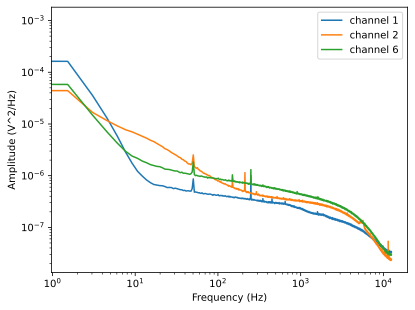

In [79]:
for name in names:
    plt.loglog(nps[name][:,0], 
               nps[name][:,1], label=f'channel {channels[name]}')
plt.legend()
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (V^2/Hz)')
plt.show()

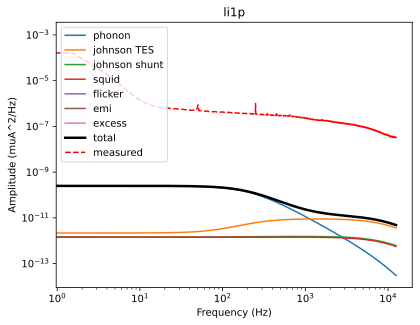

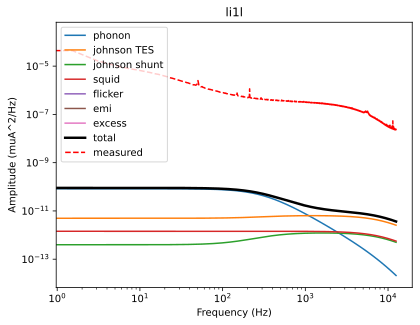

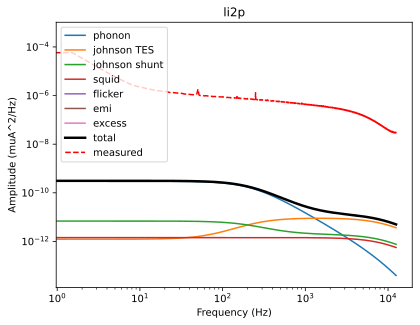

In [80]:
tes_fluct = 0.#9e-10
alpha = 2.5
p0 = 0.# 1e-12
p1 = 0.#1e-12
excess = 0.# 1e-5
i_sq = 1.2

for name in names:

    plt.loglog(utils_par['freq'], thermal_noise[name](utils_par['freq']), label='phonon')
    plt.loglog(utils_par['freq'], thermometer_johnson[name](utils_par['freq']), label='johnson TES')
    plt.loglog(utils_par['freq'], shunt_johnson[name](utils_par['freq']), label='johnson shunt')
    plt.loglog(utils_par['freq'], squid_noise[name](utils_par['freq'], i_sq), label='squid')
    plt.loglog(utils_par['freq'], one_f_noise[name](utils_par['freq'], tes_fluct, alpha), label='flicker')
    plt.loglog(utils_par['freq'], emi_noise[name](utils_par['freq'], p0, p1), label='emi')
    plt.loglog(utils_par['freq'], excess ** 2 * sev_nps[name], label='excess')

    plt.loglog(utils_par['freq'], total_noise[name](utils_par['freq'], tes_fluct, alpha, p0, p1, excess, i_sq), color='black', linewidth=2.5, label='total')
    plt.loglog(nps[name][:,0], nps[name][:,1], label='measured', color='red', linewidth=1.5, linestyle='dashed')
    
    plt.legend()
    plt.title(name)
    plt.ylabel('Amplitude (muA^2/Hz)')
    plt.xlabel('Frequency (Hz)')
    plt.show()

In [81]:
# TODO fit free parameters: tes_fluct, alpha, p0, p1, excess, i_sq = 1.2

# values table

In [1]:
from IPython.display import display, HTML
import pandas

In [ ]:
# TODO

# pars dict

In [ ]:
pars = {
    'C': ,  # pJ / mK, is defined later bec mutable
    'Gb': np.array([5e-3, 5e-3]),  # pW / mK
    'G': np.array([[0., 1e-3], [1e-3, 0.], ]),  # heat cond between components, pW / mK
    'lamb': 0.003,  # thermalization time (s)
    'eps': np.array([[0.99, 0.01], [0.1, 0.9], ]),  # share thermalization in components
    'delta': np.array([[0.02, 0.98], ]),  # share thermalization in components
    'Rs': np.array([0.035]),  # Ohm
    'Rh': np.array([10]),  # Ohm
    'L': np.array([3.5e-7]),  # H
    'Rt0': np.array([0.2]),  # Ohm
    'k': np.array([2.]),  # 1/mK
    'Tc': np.array([15.]),  # mK
    'Ib': np.array([1.]),  # muA
    'dac': np.array([0.]),  # V
    'pulser_scale': np.array([1.]),  # scale factor
    'heater_attenuator': np.array([1.]),
    'tes_flag': np.array([True, False], dtype=bool),  # which component is a tes
    'heater_flag': np.array([False, True], dtype=bool),  # which component has a heater
    'i_sq': np.array([2 * 1e-12]),  # squid noise, A / sqrt(Hz)
    'tes_fluct': np.array([2e-4]),  # ??
    'emi': np.array([2e-10]),  # ??
    'Tb': None,  # function that takes one positional argument t, returns Tb
    'tau': np.array([10]),
}


# test with cryosig

In [ ]:
# TODO

# test with cryosig with 2 tes

In [ ]:
# TODO